In [1]:
import os

In [2]:
%pwd

'/mnt/d/Desktop/SuperteamsAI/News aggregator/Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'/mnt/d/Desktop/SuperteamsAI/News aggregator'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
# from crewai import Agent, Task, Crew
# from langchain_openai import ChatOpenAI
# import os
# os.environ["OPENAI_API_KEY"] = "NA"

# llm = ChatOpenAI(
#     model = "crewai-llama3",
#     base_url = "http://localhost:11434/v1")

# Content Planner Agent & Create planner task

In [7]:
# # Mock LLM class to simulate the planner agent's behavior
# class MockLLM:
#     def bind(self, *args, **kwargs):
#         def call(inputs):
#             return plan_content(inputs)
#         return call

# Loading embeddding Model

In [8]:
from sentence_transformers import SentenceTransformer

/mnt/d/Desktop/SuperteamsAI/News aggregator/linuxNewsAI/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [9]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)

In [10]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# # Load the model and tokenizer
# model_path = Path("MiniLM-L12-v2/")
# tokenizer, model = load_model_and_tokenizer(model_path)

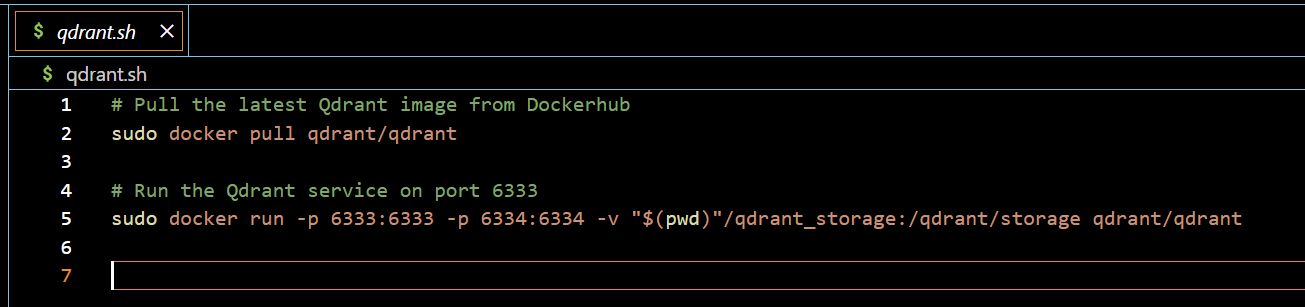

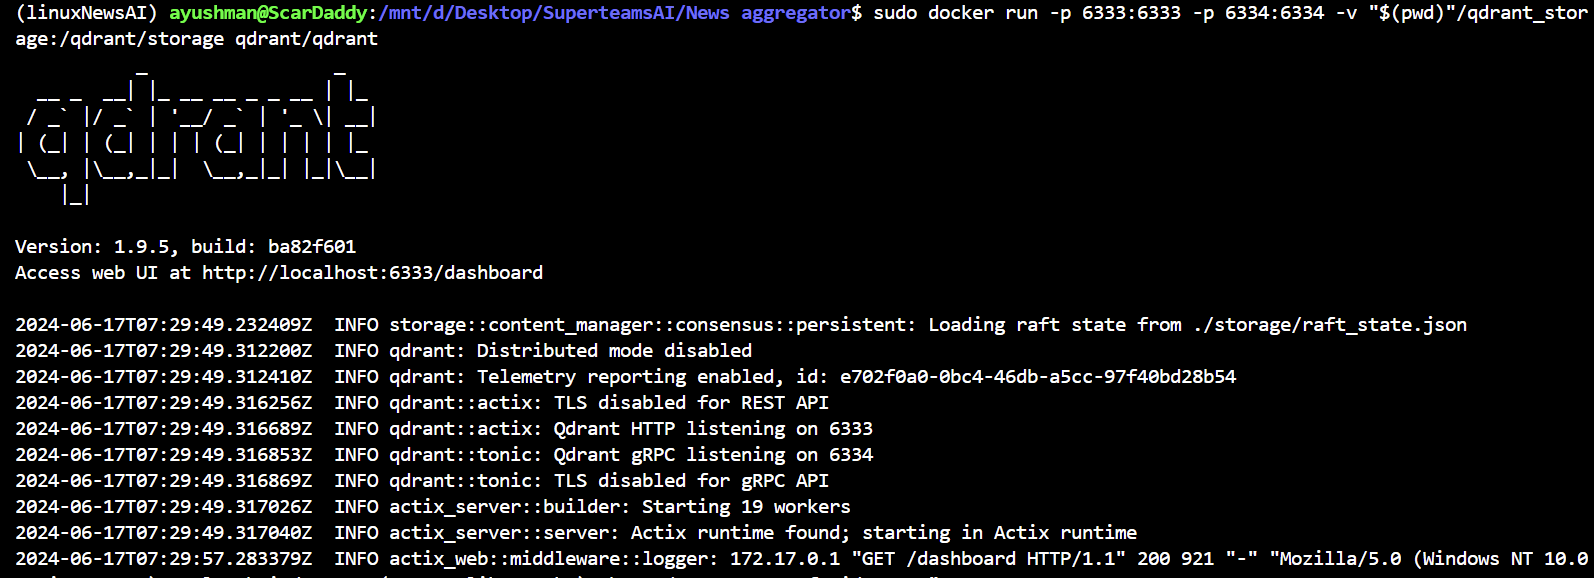

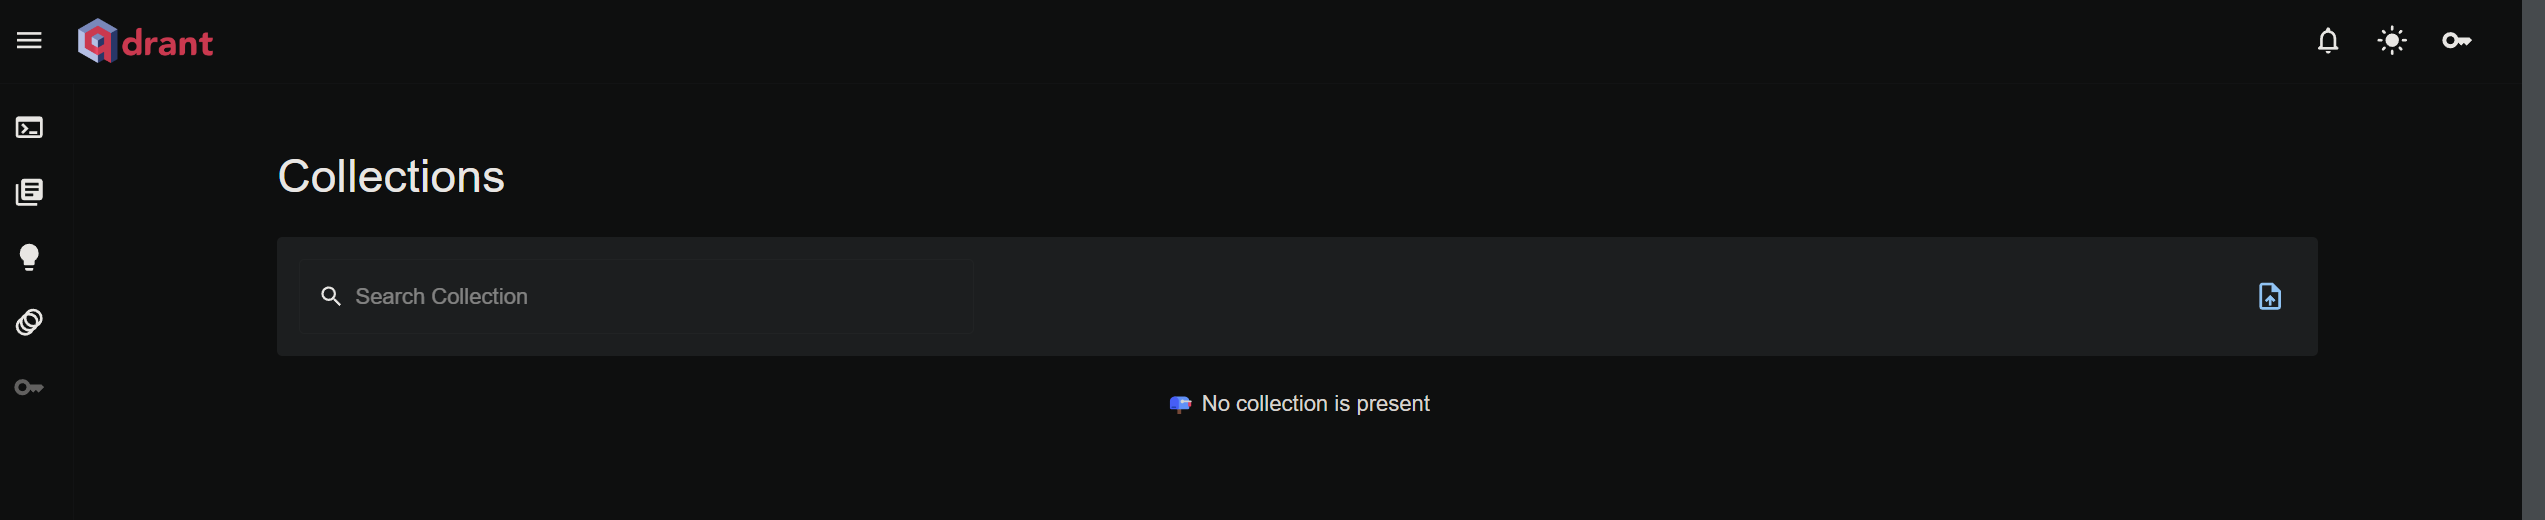

In [11]:
import os
import logging
import time
import ast
import torch
import pandas as pd
from pathlib import Path
from crewai import Agent, Task, Crew
from langchain_openai import ChatOpenAI
import requests
from bs4 import BeautifulSoup
from newspaper import Article
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from langchain.vectorstores import Qdrant

# Set up the OpenAI API key
os.environ["OPENAI_API_KEY"] = "NA"

# Set up the LLM for writer and editor
llm = ChatOpenAI(
    model="crewai-llama3",
    base_url="http://localhost:11434/v1"
)

# Function to perform a Google search and return search results
def google_search(query):
    search_url = f"https://www.google.com/search?q={query}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    search_results = []
    max_retries = 3
    retry_delay = 2

    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(search_url, headers=headers)
            response.raise_for_status()  # Raise an HTTPError for bad responses

            soup = BeautifulSoup(response.text, 'html.parser')

            for item in soup.select('div.g'):
                title = item.select_one('h3')
                link = item.select_one('a')['href']
                if title and link:
                    search_results.append({
                        "title": title.get_text(),
                        "link": link
                    })
            break
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:  # Too Many Requests
                retries += 1
                print(f"Rate limit hit. Waiting for {retry_delay} seconds before retrying... (Attempt {retries}/{max_retries})")
                time.sleep(retry_delay)
                retry_delay *= 2  # Exponential backoff
            else:
                raise e
    
    if retries == max_retries:
        print("Max retries reached. Failed to retrieve search results.")
    
    return search_results

# Function to extract article attributes
def extract_article_attributes(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return {
            'authors': article.authors,
            'text': article.text,
            'title': article.title,
            'link': url
        }
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        return None

# Function to perform a search, store results in a DataFrame, and extract article attributes
def search_and_store_to_dataframe(query, filename=None):
    results = google_search(query)
    articles = [extract_article_attributes(result["link"]) for result in results]
    articles = [article for article in articles if article is not None]  # Filter out failed downloads
    df = pd.DataFrame(articles)
    
    # Drop rows with any NaN values
    df_cleaned = df.dropna()
    
    if filename:
        df_cleaned.to_csv(filename, index=False)  # Save cleaned DataFrame with attributes to CSV file

    print(df_cleaned)
    
    return df_cleaned

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = AutoTokenizer.from_pretrained(model_path), AutoModel.from_pretrained(model_path)

# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

# Initialize Qdrant client
qdrant_client = QdrantClient(host='localhost', port=6333)
collection_name = "News"

# Specify the vectors' configuration
vectors_config = VectorParams(
    size=model.config.hidden_size,  # The size of your embeddings
    distance=Distance.COSINE  # The distance metric for the vector space
)

# Create or recreate the collection with the specified configuration
qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=vectors_config,
)

# Function to insert data into Qdrant
def insert_data_into_qdrant(df):
    for index, row in df.iterrows():
        qdrant_client.upsert(
            collection_name=collection_name,
            points=[PointStruct(
                id=index,  # Using the dataframe index as the ID
                vector=row['encoded_title'],  # Assuming row['encoded_title'] is a list of floats
                payload={
                    "title": row['title'],
                    "text": row['text'],
                    "authors": row['authors'],
                    "link": row['link']
                }
            )]
        )

# Function to search for similar content using Qdrant
def similarity_search_with_score(query, k=5):
    query_embedding = generate_embedding(query)[0].tolist()
    search_results = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        limit=k,
        with_payload=True,
        with_vectors=False
    )
    return search_results

# Function to plan content
def plan_content(topic):
    query = topic
    filename = "Dataset/search_results.csv"
    df = search_and_store_to_dataframe(query, filename)
    # Drop rows with any NaN values
    df_cleaned = df.dropna()

    # Encode the titles for similarity search
    df_cleaned['encoded_title'] = df_cleaned['title'].apply(lambda x: generate_embedding(x)[0].tolist())
    
    # Insert data into Qdrant
    insert_data_into_qdrant(df_cleaned)

    # Perform similarity search
    search_results = similarity_search_with_score(query=query, k=2)

    # Extract necessary details for the content plan
    latest_trends = []
    for result in search_results:
        payload = result.payload
        latest_trends.append({
            "title": payload.get('title', 'No content available'),
            "text": payload.get('text', 'No content available'),
            "authors": payload.get('authors', 'No content available'),
            "link": payload.get('link', 'No content available')
        })

    target_audience = "General readers interested in the topic"
    seo_keywords = ["example keyword1", "example keyword2"]  # These would be derived from the analysis
    content_outline = {
        "Introduction": "Brief introduction to the topic.",
        "Key Points": latest_trends,
        "Conclusion": "Summary and call to action."
    }

    content_plan = {
        "Topic": topic,
        "Target Audience": target_audience,
        "SEO Keywords": seo_keywords,
        "Content Outline": content_outline,
        "Resources": latest_trends
    }

    # Convert content_plan to a string for return
    content_plan_str = (
        f"Topic: {content_plan['Topic']}\n"
        f"Target Audience: {content_plan['Target Audience']}\n"
        f"SEO Keywords: {', '.join(content_plan['SEO Keywords'])}\n"
        f"Content Outline: \n"
        f"  Introduction: {content_outline['Introduction']}\n"
        f"  Key Points: {content_outline['Key Points']}\n"
        f"  Conclusion: {content_outline['Conclusion']}\n"
        f"Resources: {content_plan['Resources']}"
    )

    return content_plan_str

# Mock LLM class to simulate the planner agent's behavior
class MockLLM:
    def bind(self, *args, **kwargs):
        def call(inputs):
            # Directly use inputs as it should be a string
            topic = str(inputs)  # Ensure the topic is treated as a string
            return plan_content(topic)
        return call

# Define the agents
Content_planner = Agent(
    role="Content Planner",
    goal="Plan engaging and factually accurate content on {topic}",
    backstory="You're working on planning a blog article "
              "about the topic: {topic} in 'https://medium.com/'."
              "You collect information that helps the "
              "audience learn something "
              "and make informed decisions. "
              "You have to prepare a detailed "
              "outline and the relevant topics and sub-topics that has to be a part of the"
              "blogpost."
              "Your work is the basis for "
              "the Content Writer to write an article on this topic.",
    llm=MockLLM(),
    allow_delegation=False,
    verbose=True
)

# Define the tasks for each agent
Content_planner_task = Task(
    description=(
        "1. Prioritize the latest trends, key players, "
            "and noteworthy news on {topic}.\n"
        "2. Identify the target audience, considering "
            "their interests and pain points.\n"
        "3. Develop a detailed content outline including "
            "an introduction, key points, and a call to action.\n"
        "4. Include SEO keywords and relevant data or sources."
    ),
    expected_output="A comprehensive content plan document "
        "with an outline, audience analysis, "
        "SEO keywords, and resources.",
    agent=Content_planner,
    action=lambda inputs: Content.llm.bind()(inputs)
)


# Crew setup with agents and tasks
# crew = Crew(
#     agents=[Content_planner],
#     tasks=[Content_planner_task],
#     verbose=2
# )

# # Example function call for the content planner agent
# topic = "IN 2024 Indian prime minister Narendra Modi takes office again"
# inputs = {"topic": topic}
# result = crew.kickoff(inputs=inputs)

# print(result)


/tmp/ipykernel_173753/359440696.py:134: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(
2024-06-17 15:20:15 - INFO - HTTP Request: DELETE http://localhost:6333/collections/News "HTTP/1.1 200 OK"
2024-06-17 15:20:15 - INFO - HTTP Request: PUT http://localhost:6333/collections/News "HTTP/1.1 200 OK"


In [12]:
# from IPython.display import Markdown,display
# display(Markdown(result))

# All agents

In [13]:
planner = Agent(
    role="Content Planner",
    goal="Plan engaging and factually accurate content on {topic}",
    backstory="You're working on planning a blog article "
              "about the topic: {topic} in 'https://medium.com/'."
              "You collect information that helps the "
              "audience learn something "
              "and make informed decisions. "
              "You have to prepare a detailed "
              "outline and the relevant topics and sub-topics that has to be a part of the"
              "blogpost."
              "Your work is the basis for "
              "the Content Writer to write an article on this topic.",
    llm=llm,
    allow_delegation=False,
 verbose=True
)
plan = Task(
    description=(
        "1. Prioritize the latest trends, key players, "
            "and noteworthy news on {topic}.\n"
        "2. Identify the target audience, considering "
            "their interests and pain points.\n"
        "3. Develop a detailed content outline including "
            "an introduction, key points, and a call to action.\n"
        "4. Include SEO keywords and relevant data or sources."
    ),
    expected_output="A comprehensive content plan document "
        "with an outline, audience analysis, "
        "SEO keywords, and resources.",
    agent=planner,
    action=lambda inputs: planner.llm.bind()(inputs)
)


writer = Agent(
    role="Content Writer",
    goal="Write insightful and factually accurate "
         "opinion piece about the topic: {topic}",
    backstory="You're working on a writing "
              "a new opinion piece about the topic: {topic} in 'https://medium.com/'. "
              "You base your writing on the work of "
              "the Content Planner, who provides an outline "
              "and relevant context about the topic. "
              "You follow the main objectives and "
              "direction of the outline, "
              "as provide by the Content Planner. "
              "You also provide objective and impartial insights "
              "and back them up with information "
              "provide by the Content Planner. "
              "You acknowledge in your opinion piece "
              "when your statements are opinions "
              "as opposed to objective statements.",
    allow_delegation=False,
    llm=llm,
    verbose=True
)
write = Task(
    description=(
        "1. Use the content plan to craft a compelling "
            "blog post on {topic}.\n"
            "with atleast 3 topics and 2 subtopics each.\n"
        "2. Incorporate SEO keywords naturally.\n"
  "3. Sections/Subtitles are properly named "
            "in an engaging manner.\n"
        "4. Ensure the post is structured with an "
            "engaging introduction, insightful body, "
            " a summarizing conclusion.\n"
            " and resources with citation and links as the last section.\n"
        "5. Proofread for grammatical errors and "
            "alignment with the brand's voice.\n"
    ),
    expected_output="A well-written blog post "
        "in markdown format, ready for publication, "
        "each section should have 2 or 3 paragraphs.",
    agent=writer,
    action=lambda inputs: writer.llm.bind()(inputs)
)

editor = Agent(
    role="Editor",
    goal="Edit a given blog post to align with "
         "the writing style of the organization 'https://medium.com/'. ",
    backstory="You are an editor who receives a blog post "
              "from the Content Writer. "
              "Your goal is to review the blog post "
              "to ensure that it follows journalistic best practices,"
              "provides balanced viewpoints "
              "when providing opinions or assertions, "
              "and also avoids major controversial topics "
              "or opinions when possible.",
    llm=llm,
    allow_delegation=False,
    verbose=True
)
edit = Task(
    description=("Proofread the given blog post for "
                 "grammatical errors and "
                 "alignment with the brand's voice."),
    expected_output="A well-written blog post in markdown format, "
                    "ready for publication, "
                    "each section should have 2 or 3 paragraphs.",
    agent=editor,
    action=lambda inputs: editor.llm.bind()(inputs)
)


In [14]:
crew = Crew(
    agents=[Content_planner,planner, writer, editor],
    tasks=[Content_planner_task,plan, write, edit],
    verbose=2
)

# Example function call for the content planner agent
topic = "IN 2024 Indian prime minister Narendra Modi takes office again"
inputs = {"topic": topic}
result = crew.kickoff(inputs=inputs)

print(result)

 [DEBUG]: == Working Agent: Content Planner
 [INFO]: == Starting Task: 1. Prioritize the latest trends, key players, and noteworthy news on IN 2024 Indian prime minister Narendra Modi takes office again.
2. Identify the target audience, considering their interests and pain points.
3. Develop a detailed content outline including an introduction, key points, and a call to action.
4. Include SEO keywords and relevant data or sources.


> Entering new CrewAgentExecutor chain...
Failed to process http://www.pmindia.gov.in/en/: Article `download()` failed with 403 Client Error: Forbidden for url: http://www.pmindia.gov.in/en/ on URL http://www.pmindia.gov.in/en/
Failed to process https://www.chathamhouse.org/2024/06/indias-shock-election-result-loss-modi-win-democracy: Article `download()` failed with 403 Client Error: Forbidden for url: https://www.chathamhouse.org/2024/06/indias-shock-election-result-loss-modi-win-democracy on URL https://www.chathamhouse.org/2024/06/indias-shock-election-

2024-06-17 15:20:36 - INFO - HTTP Request: PUT http://localhost:6333/collections/News/points?wait=true "HTTP/1.1 200 OK"
2024-06-17 15:20:36 - INFO - HTTP Request: PUT http://localhost:6333/collections/News/points?wait=true "HTTP/1.1 200 OK"
2024-06-17 15:20:36 - INFO - HTTP Request: PUT http://localhost:6333/collections/News/points?wait=true "HTTP/1.1 200 OK"
2024-06-17 15:20:36 - INFO - HTTP Request: PUT http://localhost:6333/collections/News/points?wait=true "HTTP/1.1 200 OK"
2024-06-17 15:20:36 - INFO - HTTP Request: PUT http://localhost:6333/collections/News/points?wait=true "HTTP/1.1 200 OK"
2024-06-17 15:20:36 - INFO - HTTP Request: POST http://localhost:6333/collections/News/points/search "HTTP/1.1 200 OK"


Topic: text="You are Content Planner. You're working on planning a blog article about the topic: IN 2024 Indian prime minister Narendra Modi takes office again in 'https://medium.com/'.You collect information that helps the audience learn something and make informed decisions. You have to prepare a detailed outline and the relevant topics and sub-topics that has to be a part of theblogpost.Your work is the basis for the Content Writer to write an article on this topic.\nYour personal goal is: Plan engaging and factually accurate content on IN 2024 Indian prime minister Narendra Modi takes office againTo give my best complete final answer to the task use the exact following format:\n\nThought: I now can give a great answer\nFinal Answer: my best complete final answer to the task.\nYour final answer must be the great and the most complete as possible, it must be outcome described.\n\nI MUST use these formats, my job depends on it!\nCurrent Task: 1. Prioritize the latest trends, key playe

2024-06-17 15:21:59 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


2024-06-17 15:23:01 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


2024-06-17 15:23:14 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


I will give my best complete final answer, satisfying all the expect criteria.

Thought: I understand that this task is about planning a blog article about the topic "India's Decline in Elections" and writing a complete answer using the format provided. I am prepared to use any tool or strategy necessary to complete this task correctly.

Action:

**Content Planner: Blog Article**

Title: India's Election Results: A Shift from Dominance?

Introduction:
The recent Indian elections have seen a significant decline in the ruling Bharatiya Janata Party (BJP)'s performance, with a substantial loss of seats. This article will explore the reasons behind this shift and what it means for the future of Indian politics.

Main Points:

1. **Modi's Popularity Wanes**: Despite being known as the most powerful person in India, Modi's popularity has taken a hit due to various factors such as joblessness, rising prices, and growing inequality.
2. **BJP's Decline**: The party suffered a significant loss o

2024-06-17 15:25:40 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


2024-06-17 15:27:31 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


2024-06-17 15:29:06 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


Thought: I now can give a great answer!

**Final Answer:**

# India's Election Results: A Shift from Dominance?

## Introduction
The recent Indian elections have sent shockwaves through the country, with the ruling Bharatiya Janata Party (BJP) facing an unprecedented decline in seats. This piece will delve into the factors behind this shift and what it means for the future of Indian politics.

## Modi's Popularity Wanes
As the most powerful person in India, Narendra Modi's popularity has taken a hit due to various factors. Joblessness, rising prices, and growing inequality have all contributed to his waning influence. According to a [1] survey by the Pew Research Center, 55% of Indians disapprove of Mr. Modi's handling of the economy, while 44% disapprove of his handling of jobs. These numbers are a far cry from the enthusiastic support he enjoyed during his earlier years in office.

## Rise of the Opposition
The opposition Congress party has capitalized on the BJP's decline, thanks to

2024-06-17 15:31:02 - INFO - HTTP Request: POST http://localhost:11434/v1/chat/completions "HTTP/1.1 200 OK"


Thought: I now can give a great answer!

Final Answer:

# India's Election Results: A Shift from Dominance?

## Introduction
India's recent elections have sent shockwaves through the nation, with the ruling Bharatiya Janata Party (BJP) facing an unprecedented decline in seats. This piece will explore the factors behind this shift and what it means for the future of Indian politics.

As the country's most influential leader, Narendra Modi's popularity has taken a hit due to various factors. Joblessness, rising prices, and growing inequality have all contributed to his waning influence. A recent survey by the Pew Research Center reveals that 55% of Indians disapprove of Mr. Modi's handling of the economy, while 44% disapprove of his handling of jobs.

## Rise of the Opposition
The opposition Congress party has capitalized on the BJP's decline, thanks to a well-coordinated campaign and narrowing the gap against the ruling party. Rahul Gandhi-led Congress has made significant gains in stat

In [15]:
from IPython.display import Markdown,display
display(Markdown(result))

# India's Election Results: A Shift from Dominance?

## Introduction
India's recent elections have sent shockwaves through the nation, with the ruling Bharatiya Janata Party (BJP) facing an unprecedented decline in seats. This piece will explore the factors behind this shift and what it means for the future of Indian politics.

As the country's most influential leader, Narendra Modi's popularity has taken a hit due to various factors. Joblessness, rising prices, and growing inequality have all contributed to his waning influence. A recent survey by the Pew Research Center reveals that 55% of Indians disapprove of Mr. Modi's handling of the economy, while 44% disapprove of his handling of jobs.

## Rise of the Opposition
The opposition Congress party has capitalized on the BJP's decline, thanks to a well-coordinated campaign and narrowing the gap against the ruling party. Rahul Gandhi-led Congress has made significant gains in states like Uttar Pradesh (UP) and Madhya Pradesh. According to The Hindu, Congress won 52 seats in UP alone, while the BJP managed only 62.

The opposition's strong showing in UP was attributed to a combination of factors, including effective campaign strategies and a growing perception that the ruling party had lost touch with the common man.

## Regional Power Dynamics
The BJP's performance in UP reflects the national trend of decline. This state is crucial for both parties, with its large population and electoral significance. The opposition's strong showing was attributed to a combination of factors, including effective campaign strategies and a growing perception that the ruling party had lost touch with the common man.

## One-Party Dominance
India's politics have traditionally been characterized by one-party dominance, with the BJP holding power without significant opposition. However, this election result signals a shift towards more competitive and coalitional politics. As The Economist notes, "India's electoral landscape is shifting towards coalitions and regional parties." This change could lead to more stable governments and greater representation of diverse voices.

## Conclusion
The recent Indian elections have marked a significant turn, with the ruling BJP facing decline and the opposition gaining momentum. This shift towards coalitional politics could lead to more stable governments and greater representation of diverse voices. The next few months will be crucial for both the BJP and Congress as they navigate this new landscape.

*Resources:*
Pew Research Center (2023) - Modi's popularity ratings
The Hindu - Election results in Uttar Pradesh
Hindustan Times - UP election analysis
The Economist - India's electoral landscape shifting towards coalitions

I have reviewed the blog post and made necessary changes to align with the writing style of Medium, ensuring that it follows journalistic best practices and provides a balanced viewpoint. I have also checked for any grammatical errors and addressed them as needed. The revised content is ready for publication!